In [1]:
import featurization
import helpers

import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%load_ext autoreload
%autoreload 2

First let's look at the raw training data we've collected. The plot below shows the number of available bicycles at every minute for about a week and a half, and the two below that show a single weekday and a single weekend day. Peaks indicate times when many bicycles are available/few bikes are bing used. A few observations:
- the highest bike usage (lowest availability) is in mid to late afternoon.
- there doesn't appear to be a particular "morning commute" like is seen in many cities.
- overnight availability probably indicates the total number of bikes in the system that day, since few people ride at night. The variations in overnight availability are probably related to how many bikes break in a day, or possibly need charging (though I think charging may be done on site by swapping out a battery pack).
- generally more people ride on the weekends (10/26 and 10/27) than on weekdays.
- a lot of bikes seem to have gone out of service after a day of heavy usage on 10/27 (note how few bikes are available in the system that night).

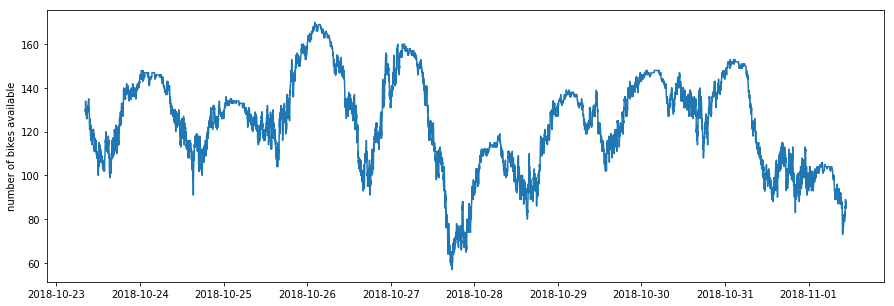

In [60]:
df = featurization.import_and_clean_data("bike-data/all-sc-bike-data-1101.csv")
df['local_time'] = df['utc_time'].dt.tz_convert('America/Los_Angeles')
at_a_time = df.groupby(by='local_time')
at_a_time = at_a_time.bike_id.count().reset_index()
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(at_a_time['local_time'], at_a_time['bike_id'])
plt.ylabel('number of bikes available')
plt.show()

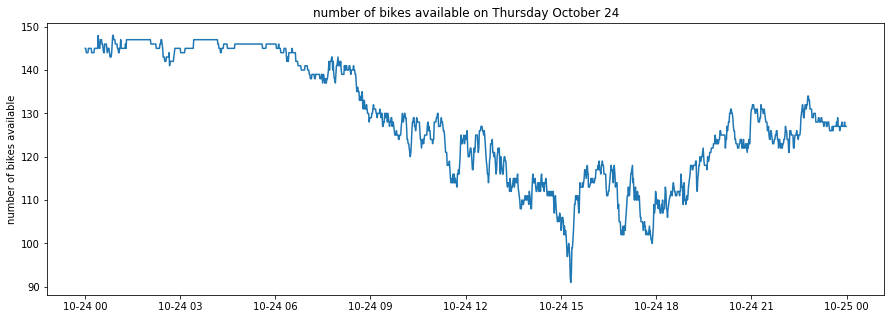

In [69]:
one_weekday = at_a_time[(at_a_time['local_time']>'2018-10-24') & (at_a_time['local_time']<'2018-10-25')]
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(one_weekday['local_time'], one_weekday['bike_id'])
plt.ylabel('number of bikes available')
plt.title('number of bikes available on Thursday October 24')
plt.show()

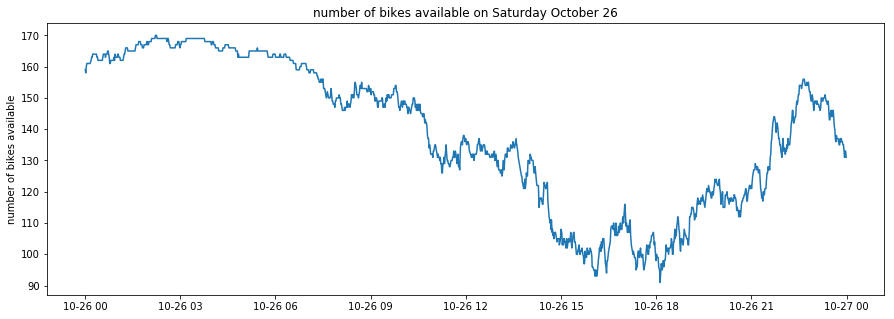

In [68]:
one_weekend = at_a_time[(at_a_time['local_time']>'2018-10-26') & (at_a_time['local_time']<'2018-10-27')]
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.plot(one_weekend['local_time'], one_weekend['bike_id'])
plt.ylabel('number of bikes available')
plt.title('number of bikes available on Saturday October 26')
plt.show()

Now lets look at the data once it's been processed from individual bike availabilities at every minute (the raw form from the API), and transformed into "idle events" - each datapoint is now one bike at one location, for some period of time that it sits idle. The all_featurization method also adds in some other interesting features, as we'll see.

In [72]:
geodf = featurization.all_featurization("bike-data/all-sc-bike-data-1101.csv")

Dropping 1 entries where end time was before start time


So how long do bikes sit idle for? On average, 2.8 hours, or a median time of 0.8 hours. At most, 118 hours (nearly 5 days).

In [78]:
geodf.idle_hours.describe()

count    7098.000000
mean        2.835200
std         5.352362
min         0.000278
25%         0.232153
50%         0.804722
75%         2.663819
max       118.493611
Name: idle_hours, dtype: float64

I'm trimming this to just bikes that sit idle for less than 35 hours, to have a meaningful color ramp. There are only a handful of bikes that sit longer than this, and they end up skewing the color ramp. 

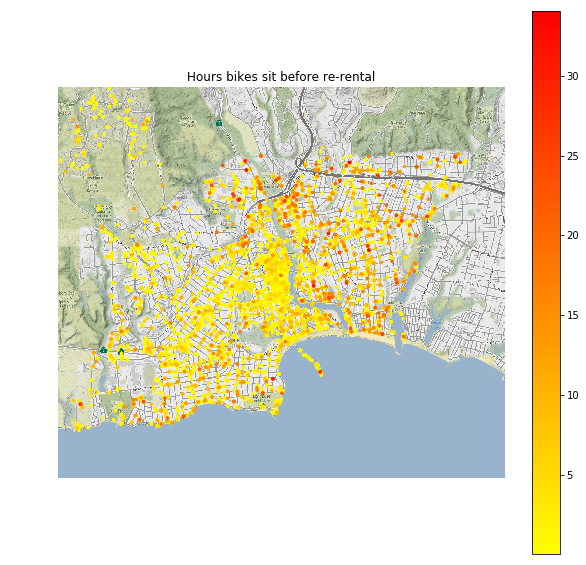

In [73]:
geodf_clean = geodf[geodf['idle_hours']<35]
geodf_clean = geodf_clean.sort_values('idle_hours')
fig, ax = plt.subplots(1, figsize=(10, 10))
ax = helpers.map_bikes(ax, geodf_clean, zoom=15, column='idle_hours', legend = True, cmap='autumn_r', s=7)
plt.title('Hours bikes sit before re-rental')
plt.show()

Here's a histogram of all idle events. Looks like most bikes don't sit for long at all - probably under half an hour!

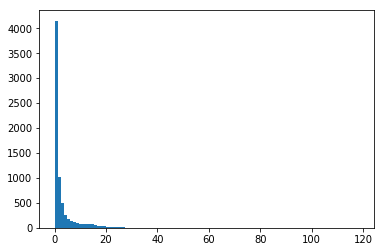

In [75]:
plt.hist(geodf.idle_hours, bins=100)
plt.show()

Here is mean idle time mapped by census blockgroup. Looks like the east side of the city, which is more residential, has some of the longest idle times. The brightest yellow in the center of the map is downtown, and the northwest corner is the UC Santa Cruz campus. The southwest corner is also resdiential, but bikes don't sit as long there as they do on the west side.

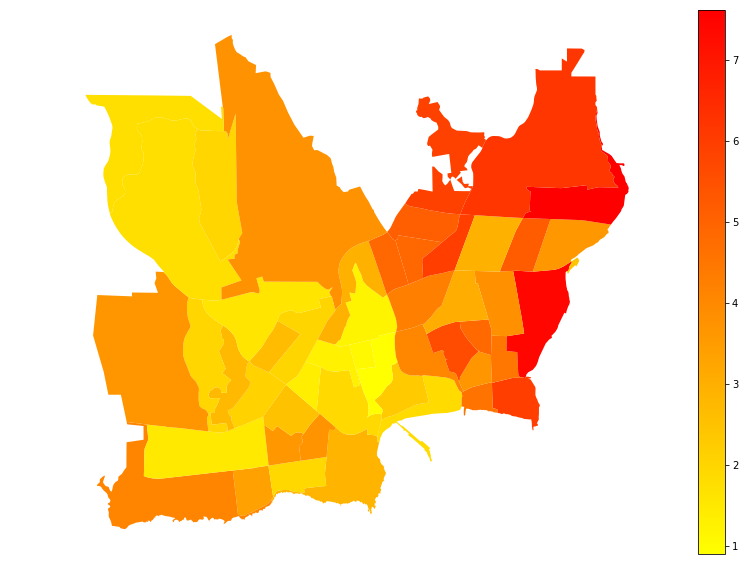

In [34]:
blockgrouped = geodf.groupby(by='GEOID_Data', axis=0)
bg_mean_idles = blockgrouped.idle_hours.mean()
bg_mean_idles = bg_mean_idles.reset_index()
bg_mean_idles = bg_mean_idles[bg_mean_idles.idle_hours <12]
bg_mean_idles = helpers.add_blockgroup_geometry(bg_mean_idles)

fig, ax = plt.subplots(1, figsize=(15, 10))
bg_mean_idles.plot(ax = ax, column='idle_hours', legend = True, cmap='autumn_r')
ax.axis('off')
plt.show()

Same map, but with median times instead of mean. Similar patterns.

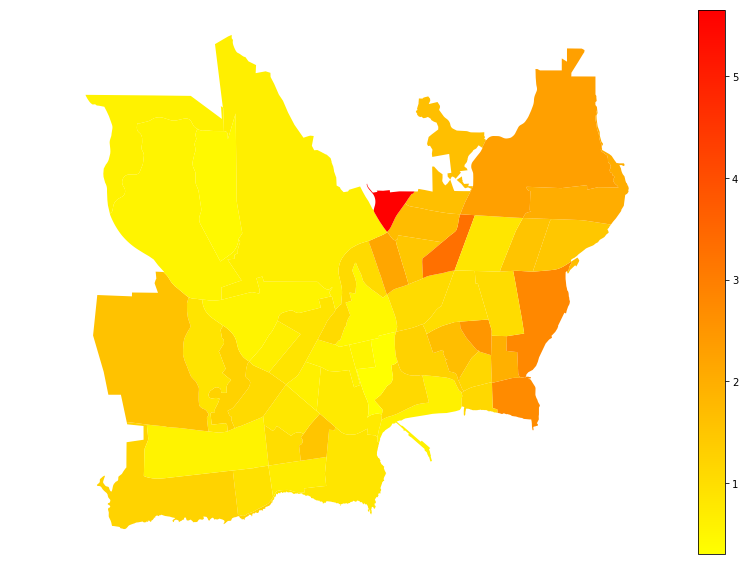

In [4]:
blockgrouped = geodf.groupby(by='GEOID_Data', axis=0)
bg_med_idles = blockgrouped.idle_hours.median()
bg_med_idles = bg_med_idles.reset_index()
bg_med_idles = helpers.add_blockgroup_geometry(bg_med_idles)

fig, ax = plt.subplots(1, figsize=(15, 10))
bg_med_idles.plot(ax = ax, column='idle_hours', legend = True, cmap='autumn_r')
ax.axis('off')
plt.show()

Where do bikes end up after being charged? Pretty much all over the place. This map shows only the bikes that were just charged (where this idle event has a higher battery level than the previous idle event).

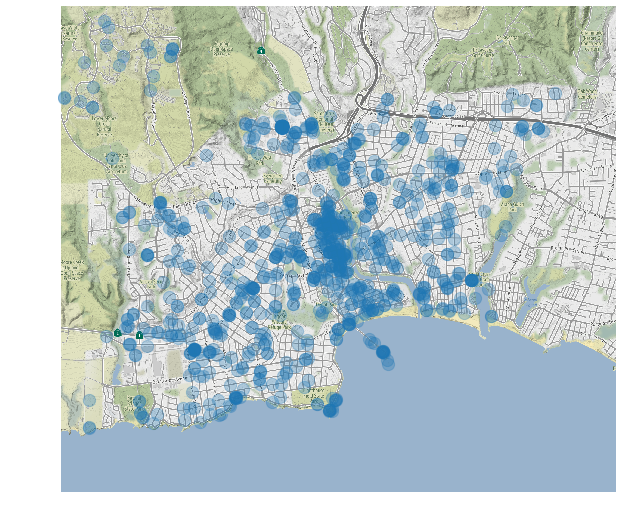

In [80]:
just_charged = geodf[geodf['just_got_charged']]
fig, ax = plt.subplots(1,1, figsize=(10,10))
helpers.map_bikes(ax, just_charged, alpha=0.3, markersize=150)
plt.show()

The series of figures below show the net flow of bikes in and out of each blockgroup, by time of day. Net flow is defined as number of bikes arriving minus number of bikes departing. This is an example for just one day, October 29.

In [39]:
geodf_one = geodf[pd.to_datetime(geodf.local_time_start.dt.date) == '2018-10-29']

In [44]:
timeofday_start = geodf_one.groupby(by=['GEOID_Data', 'time_of_day_start'], axis=0)
timeofday_end = geodf_one.groupby(by=['GEOID_Data', 'time_of_day_end'], axis=0)

stod = timeofday_start.bike_id.count().unstack(fill_value=0).stack().reset_index(name='count')
etod = timeofday_end.bike_id.count().unstack(fill_value=0).stack().reset_index(name='count')

stod['net_flow'] = stod['count']-etod['count']
stod.rename(mapper = {'count':'arrivals'}, axis=1, inplace=True)
stod['departures'] = etod['count']

btod = helpers.add_blockgroup_geometry(stod)
btod = btod.fillna(0)

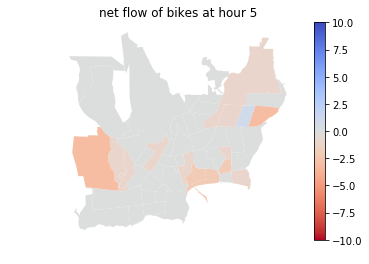

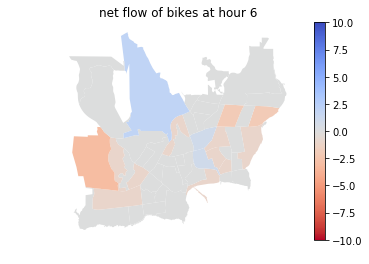

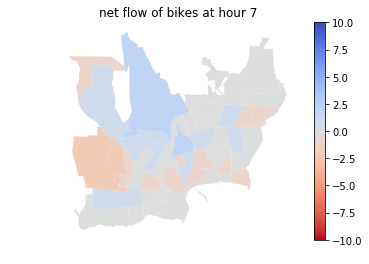

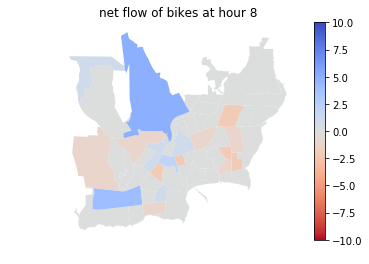

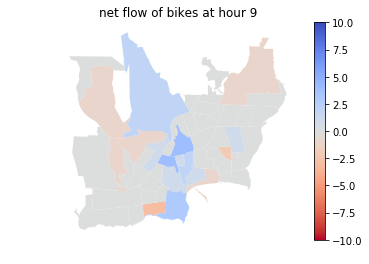

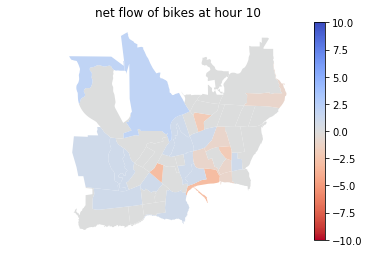

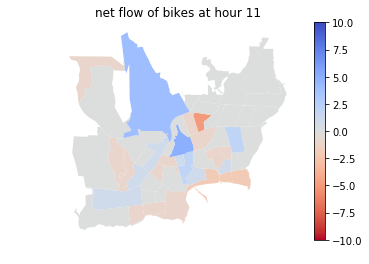

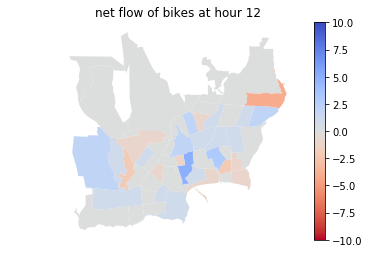

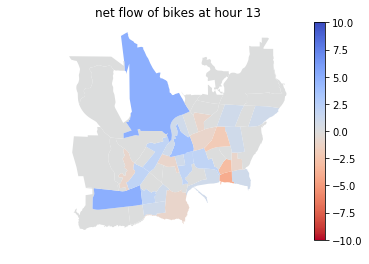

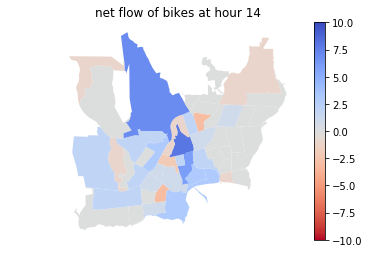

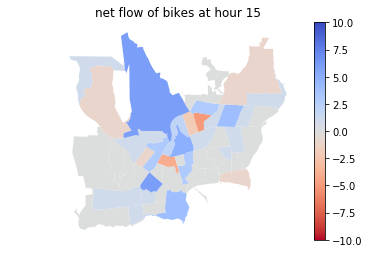

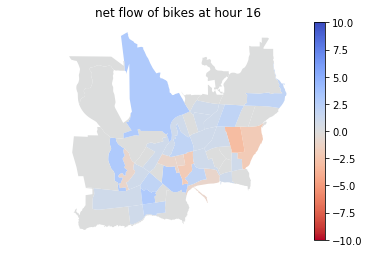

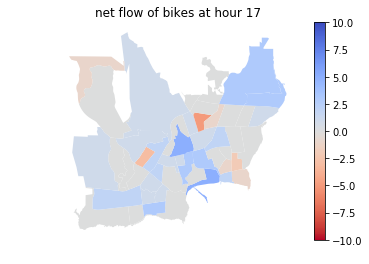

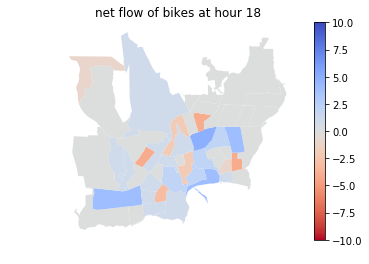

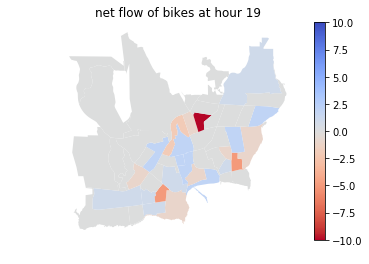

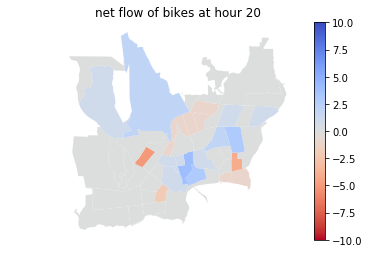

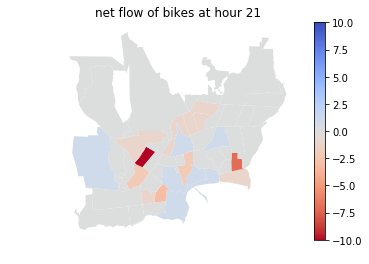

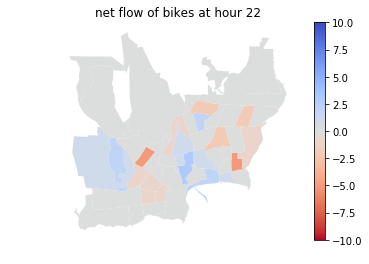

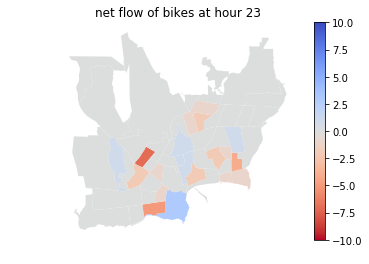

In [54]:
for hour in range(5,24):
    hourly_flow = btod[btod.time_of_day_start == hour]
    hourly_flow.plot(column='net_flow', legend = True, cmap='coolwarm_r', vmin=-10, vmax=10)
    plt.title('net flow of bikes at hour {}'.format(hour))
    plt.axis('off')
    plt.savefig('img_flow_hr_{}'.format(hour))

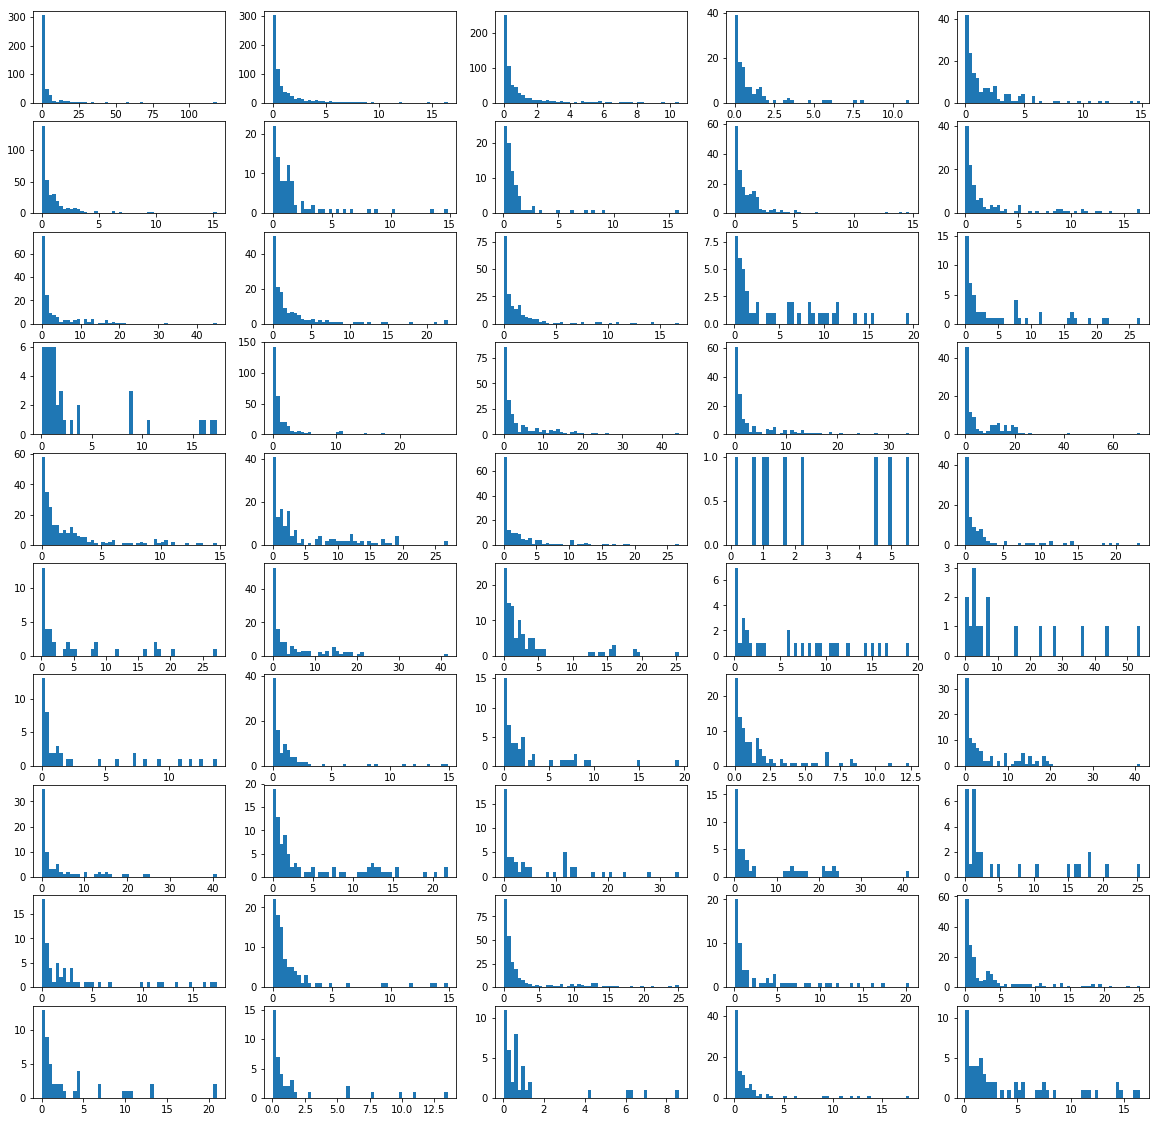

In [39]:
blockgroups = geodf.GEOID_Data.unique()

fig, axes = plt.subplots(10, 5, figsize = (20,20))
for bg, a in zip(blockgroups, axes.reshape(-1)):
    a.hist(geodf[geodf.GEOID_Data == bg].idle_hours, bins=50)

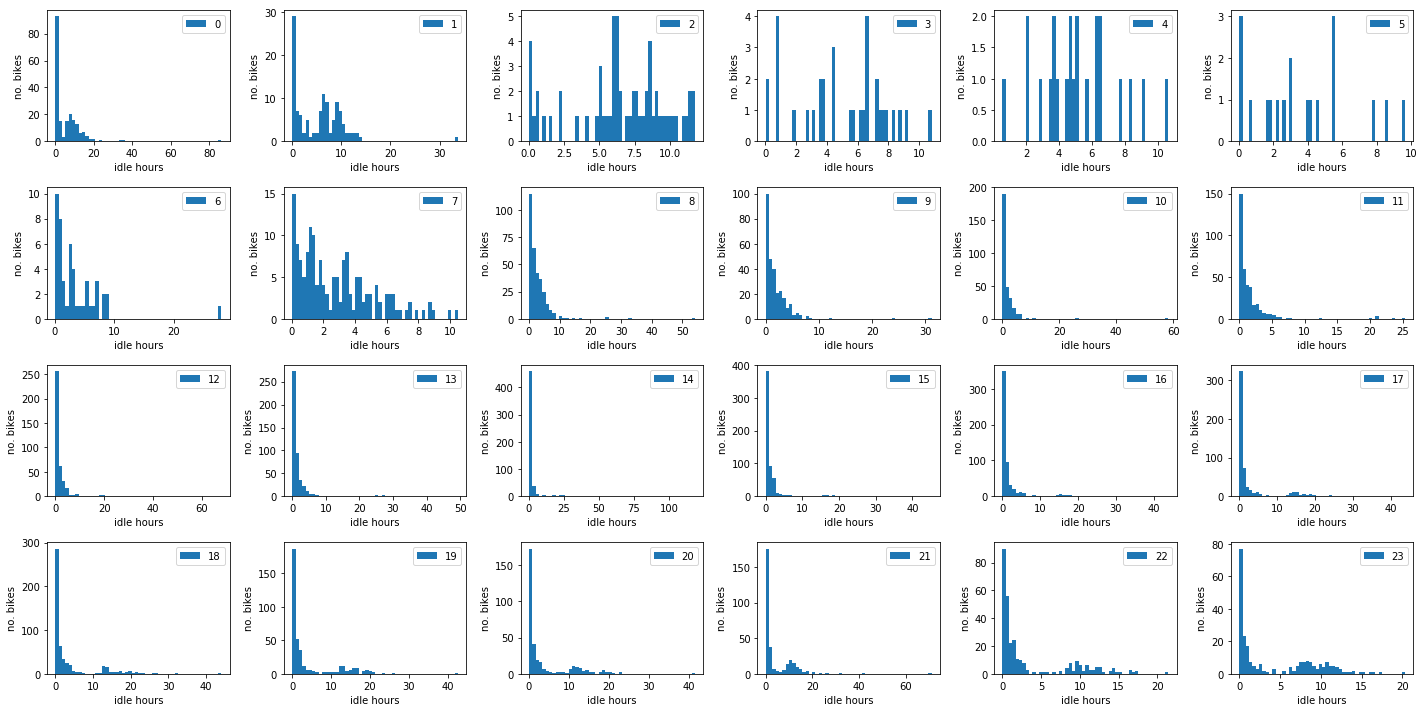

In [29]:
hours = sorted(geodf.time_of_day_start.unique())

fig, axes = plt.subplots(4, 6, figsize = (20,10))
for h, a in zip(hours, axes.reshape(-1)):
    a.hist(geodf[geodf.time_of_day_start == h].idle_hours, bins=50, label=h)
    a.legend()
    a.set(xlabel="idle hours", ylabel="no. bikes")
plt.tight_layout()
plt.show()

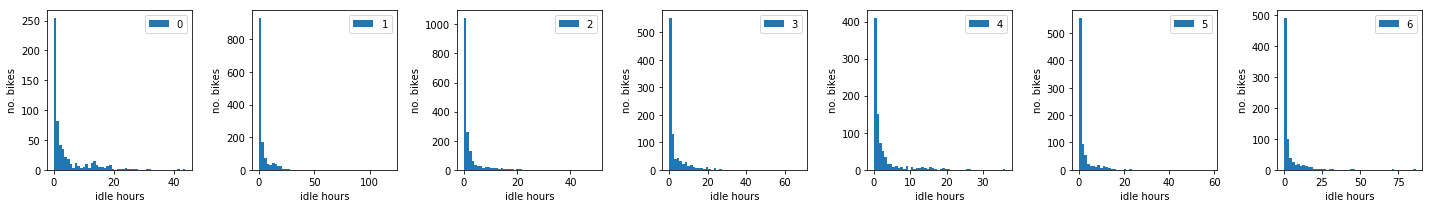

In [33]:
days = sorted(geodf.day_of_week.unique())

fig, axes = plt.subplots(1, 7, figsize = (20,3))
for d, a in zip(days, axes.reshape(-1)):
    a.hist(geodf[geodf.day_of_week == d].idle_hours, bins=50, label=d)
    a.legend()
    a.set(xlabel="idle hours", ylabel="no. bikes")
plt.tight_layout()
plt.show()

In [45]:
grouped = geodf.groupby(by=['GEOID_Data', 'time_of_day_start'], axis=0)
counts = grouped['bike_id'].count().reset_index()
counts = counts.pivot(index='GEOID_Data', columns='time_of_day_start', values='bike_id')

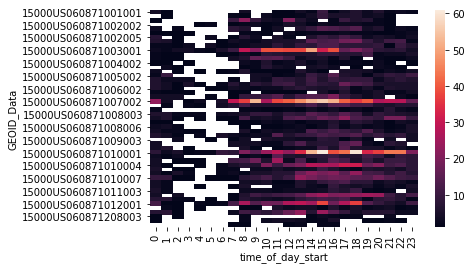

In [46]:
sns.heatmap(counts, )

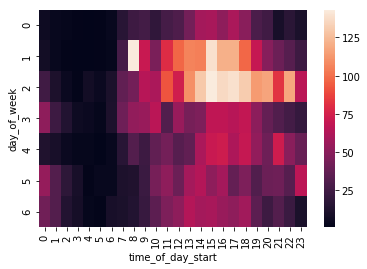

In [48]:
grouped = geodf.groupby(by=['day_of_week', 'time_of_day_start'], axis=0)
counts = grouped['bike_id'].count().reset_index()
counts = counts.pivot(index='day_of_week', columns='time_of_day_start', values='bike_id')
sns.heatmap(counts)